In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib import animation as am
from matplotlib import cm
from scipy.integrate import ode 
from kuramoto import * # import the kuramoto classes from file 
from utils import *

## First, we do some 1D simulations.  

In [83]:
# Set up model parameters 
epsilon = 1
gamma = 0
sigmas = [0.1, 0.01, 0] 
mean_omega = 1

# Set up simulation parameters 
L = 64 # size of the system 
T = 1e3 # total time of the simulation 
dt = 1e-2 # time step 
n_batches = T # number of time points recorded in the end 
init = np.zeros((L))  # - 0.1*np.sin(np.arange(L)*np.pi/L)
grad = [-0.01, 0.01]

seed= 100

data = [] 

for (i, sigma) in enumerate(sigmas): 
    # Initialise the model and run the simulation 
    model = Kuramoto(epsilon, gamma, sigma, mean_omega, BC='grad', grad=grad)
    model.initialise(L, T, dt, n_batches, init=init, seed=seed) 
    model.evolve(verbose=False) # this runs the simulation, set verbose to True to see output at every time step 
    
    phases = np.copy(model.res[-2]) % (2*np.pi)
    shift(phases)
    data.append(phases)

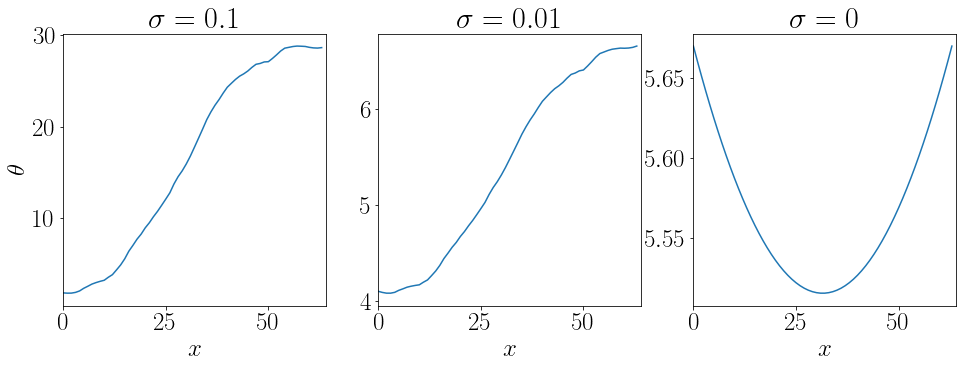

In [84]:
plt.rc('text', usetex=True)
plt.rc('font', size=25, family='serif')
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for (i, sigma) in enumerate(sigmas):
    axes[i].plot(data[i])
    axes[i].set_title(r'$\sigma={}$'.format(sigma))
    axes[i].set_xlabel(r'$x$')
    axes[i].set_xlim([0, 64])

axes[0].set_ylabel(r'$\theta$')
plt.savefig('sim.pdf')
plt.show() 

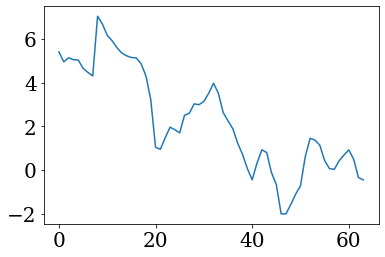

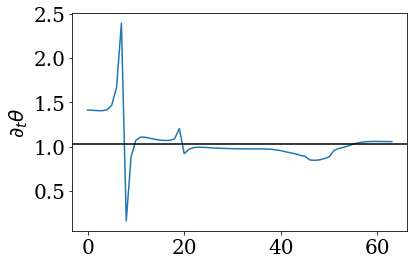

In [57]:
phases = np.copy(model.res[-2]) % (2*np.pi)
shift(phases)
plt.plot(phases)
plt.show() 


data = phases
Omega = 2*gamma*np.sum(1 - np.cos(data[1:] - data[:-1]))/L
Omega += (np.sin(data[-1]-data[-2]) - np.sin(data[1]-data[0]))/L 
Omega += np.mean(model.omegas)
plt.plot(model._det_rhs(phases))
plt.ylabel(r'$\partial_t \theta$')
plt.axhline(y=Omega, color='k')
plt.show() 

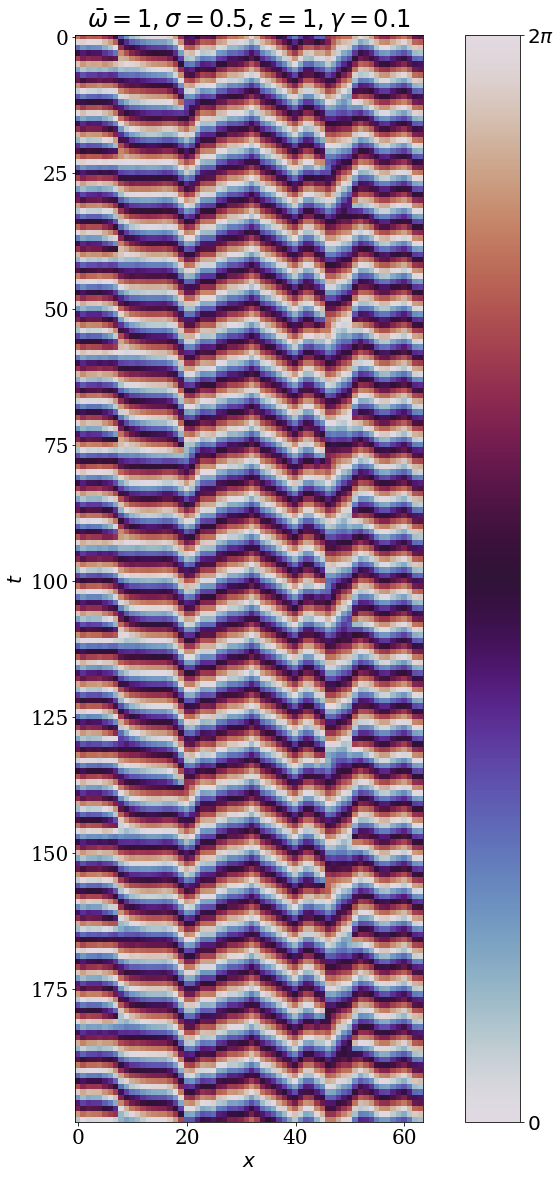

In [52]:
plt.figure(figsize=(15, 20))
plt.rc('font', size=20)
plt.rc('text', usetex=False)
im = plt.imshow(model.res[-200:] % (np.pi*2), cmap='twilight', vmin=0, vmax=2*np.pi)
cbar = plt.colorbar(im)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$2\pi$'])
plt.title(r'$\bar{{\omega}}={}, \sigma={}, \epsilon ={}, \gamma ={}$'.format(mean_omega, sigma, epsilon, gamma))
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.show() 

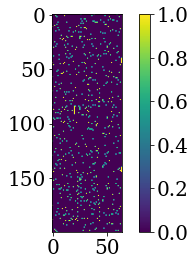

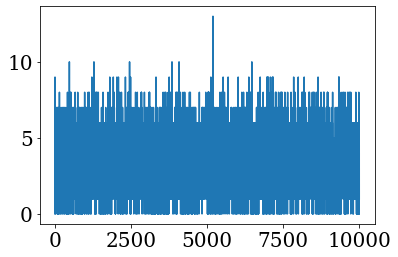

In [50]:
phases = model.res % (np.pi*2)
m = (phases < np.pi) & (phases > 0.9*np.pi)
plt.imshow(m[-200:], interpolation=None)
plt.colorbar() 
plt.show() 

production = np.sum(m, axis=-1)
plt.plot(production)
plt.show() 

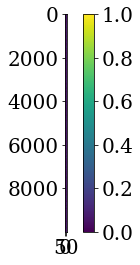

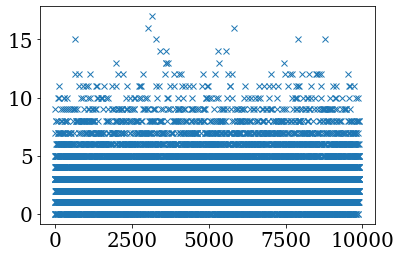

In [56]:
phases = model.res % (np.pi*2)
m = (phases < np.pi) & (phases > 0.9*np.pi)
plt.imshow(m[:], interpolation=None)
plt.colorbar() 
plt.show() 

production = np.sum(m, axis=-1)
plt.plot(production[100:], 'x')
plt.show() 

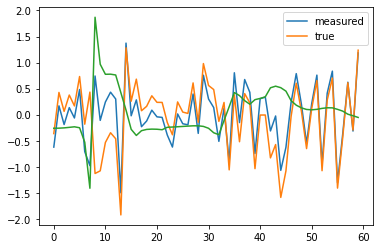

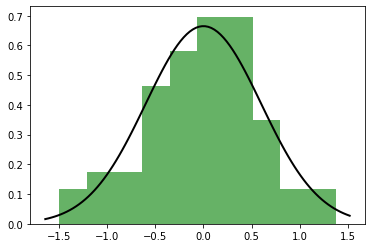

MAP estimate for gamma: 0.024280347919563995 with error 0.06962062229721142
MAP estimate for sigma: 0.5859746926252741 with error 0.05354848598448318


/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


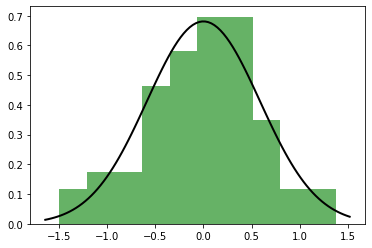

In [4]:
freqs = get_freqs(phases[1:-1], gamma)
plt.plot(freqs, label='measured')
plt.plot(model.omegas[2:-2] - mean_omega, label='true')
plt.plot(freqs-(model.omegas[2:-2] - mean_omega))
plt.legend() 
plt.show() 

plot(freqs, gamma, sigma)

map_gamma =MAP_gamma(phases[1:-1], 1.1, 0.5)
map_sigma = MAP_sigma(phases[1:-1], map_gamma)
gamma_error, sigma_error = errors(phases[1:-1], map_gamma, map_sigma, 1.1, 0.5)
print('MAP estimate for gamma: {} with error {}'.format(map_gamma, gamma_error))
print('MAP estimate for sigma: {} with error {}'.format(map_sigma, sigma_error))
plot(freqs, map_gamma, map_sigma)

## Then, we plot the spacetime graph of the phase evolution 

In [2]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=20)
plt.rc('text', usetex=True)

phases = model.res[-100:] % (np.pi*2)

breakpoints = [x*2*np.pi for x in [0.47, 0.67]]
indexed_phases = np.zeros_like(phases) 
indexed_phases[phases > breakpoints[0]] = 1 
indexed_phases[phases > breakpoints[1]] = 2 

cmap = cm.get_cmap('PiYG', 3)  
im = plt.imshow(indexed_phases, cmap=cmap)
cbar = plt.colorbar(im)
plt.title(r'$\bar{{\omega}}={}, \sigma={}, \epsilon ={}, \gamma ={}$'.format(mean_omega, sigma, epsilon, gamma))
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.show() 

NameError: name 'plt' is not defined

## Next, we set up and run some 2D simulations 

In [5]:
# Set up model parameters 
epsilon = 1 
gamma = 0.4
sigma = 0.3
mean_omega = 1 

# Set up simulation parameters 
Lx = 128
Ly = 20
T = 1e2
dt = 1e-2
n_batches = T

# Initialise the model and run the simulation 
model = Kuramoto2D(epsilon, gamma, sigma, mean_omega)
model.initialise(Lx, Ly, T, dt, n_batches)
model.evolve() 

## Make movie of the 2D simulation 

In [6]:
# Reshape the result into 2D shape 
phase_evolution = model.res.reshape((model.n_batches, model.Lx, model.Ly))

# Set up figure plotting 
fig = plt.figure(figsize=(20, 5))
low, high = 0, 2*np.pi 

plt.rc('font', size=20)
plt.rc('text', usetex=True)

# Plot the movie one snapshot at a time 
ims = []
im = plt.imshow(phase_evolution[0].T, vmin=low, vmax=high, animated=True, cmap='twilight')
plt.title(r'$\sigma={}, \epsilon ={}, \gamma ={}$'.format(sigma, epsilon, gamma))
plt.axis('off')
cbar = plt.colorbar(im, shrink=0.6)
cbar.set_ticks([0, 2*np.pi])
cbar.set_ticklabels([r'0', r'$2\pi$'])
plt.tight_layout()
for i in range(model.n_batches):
    xy = phase_evolution[i].T % 2*np.pi 
    im = plt.imshow(xy, vmin=low, vmax=high, animated=True, cmap='twilight')
    plt.axis('off')
    ims.append([im])
ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)
mywriter = am.FFMpegWriter()
ani.save("movie.mp4", writer=mywriter)
plt.close()


## Now you will find a video called "movie.mp4" in the same folder